In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### BÀI TẬP BÀI TẬP 2.1.4: CÂY QUYẾT ĐỊNH VÀ RỪNG CÂY - BỆNH TIỂU ĐƯỜNG

#### PHẦN 1: NẠP VÀ KHÁM PHÁ DỮ LIỆU

In [2]:
print("\n[1] NẠP VÀ KHÁM PHÁ DỮ LIỆU")
print("-" * 70)

try:
    df = pd.read_csv('diabetes_prediction_dataset.csv')
    print("Đã nạp dữ liệu thành công!")
except FileNotFoundError:
    print("Không tìm thấy file 'diabetes_prediction_dataset.csv'")
    print("Vui lòng tải dataset từ:")
    print("https://www.kaggle.com/code/tumpanjawat/diabetes-eda-random-forest-hp")
    exit()

print(f"\nKích thước dữ liệu: {df.shape}")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nThông tin dataset:")
print(df.info())
print(f"\n5 dòng đầu tiên:")
print(df.head())

print(f"\nThống kê mô tả:")
print(df.describe())

print(f"\nPhân bố nhãn diabetes:")
print(df['diabetes'].value_counts())
print(f"Tỷ lệ: \n{df['diabetes'].value_counts(normalize=True)}")

# Kiểm tra giá trị bất thường (0 không hợp lý)
print(f"\nKiểm tra giá trị 0 (bất thường):")
zero_cols = ['hypertension', 'heart_disease', 'blood_glucose_level', 'HbA1c_level', 'bmi']
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} giá trị 0 ({zero_count/len(df)*100:.2f}%)")


[1] NẠP VÀ KHÁM PHÁ DỮ LIỆU
----------------------------------------------------------------------
Đã nạp dữ liệu thành công!

Kích thước dữ liệu: (100000, 9)

Các cột: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float

#### PHẦN 2: PHÂN TÍCH TRỰC QUAN DỮ LIỆU



[2] PHÂN TÍCH TRỰC QUAN DỮ LIỆU
----------------------------------------------------------------------


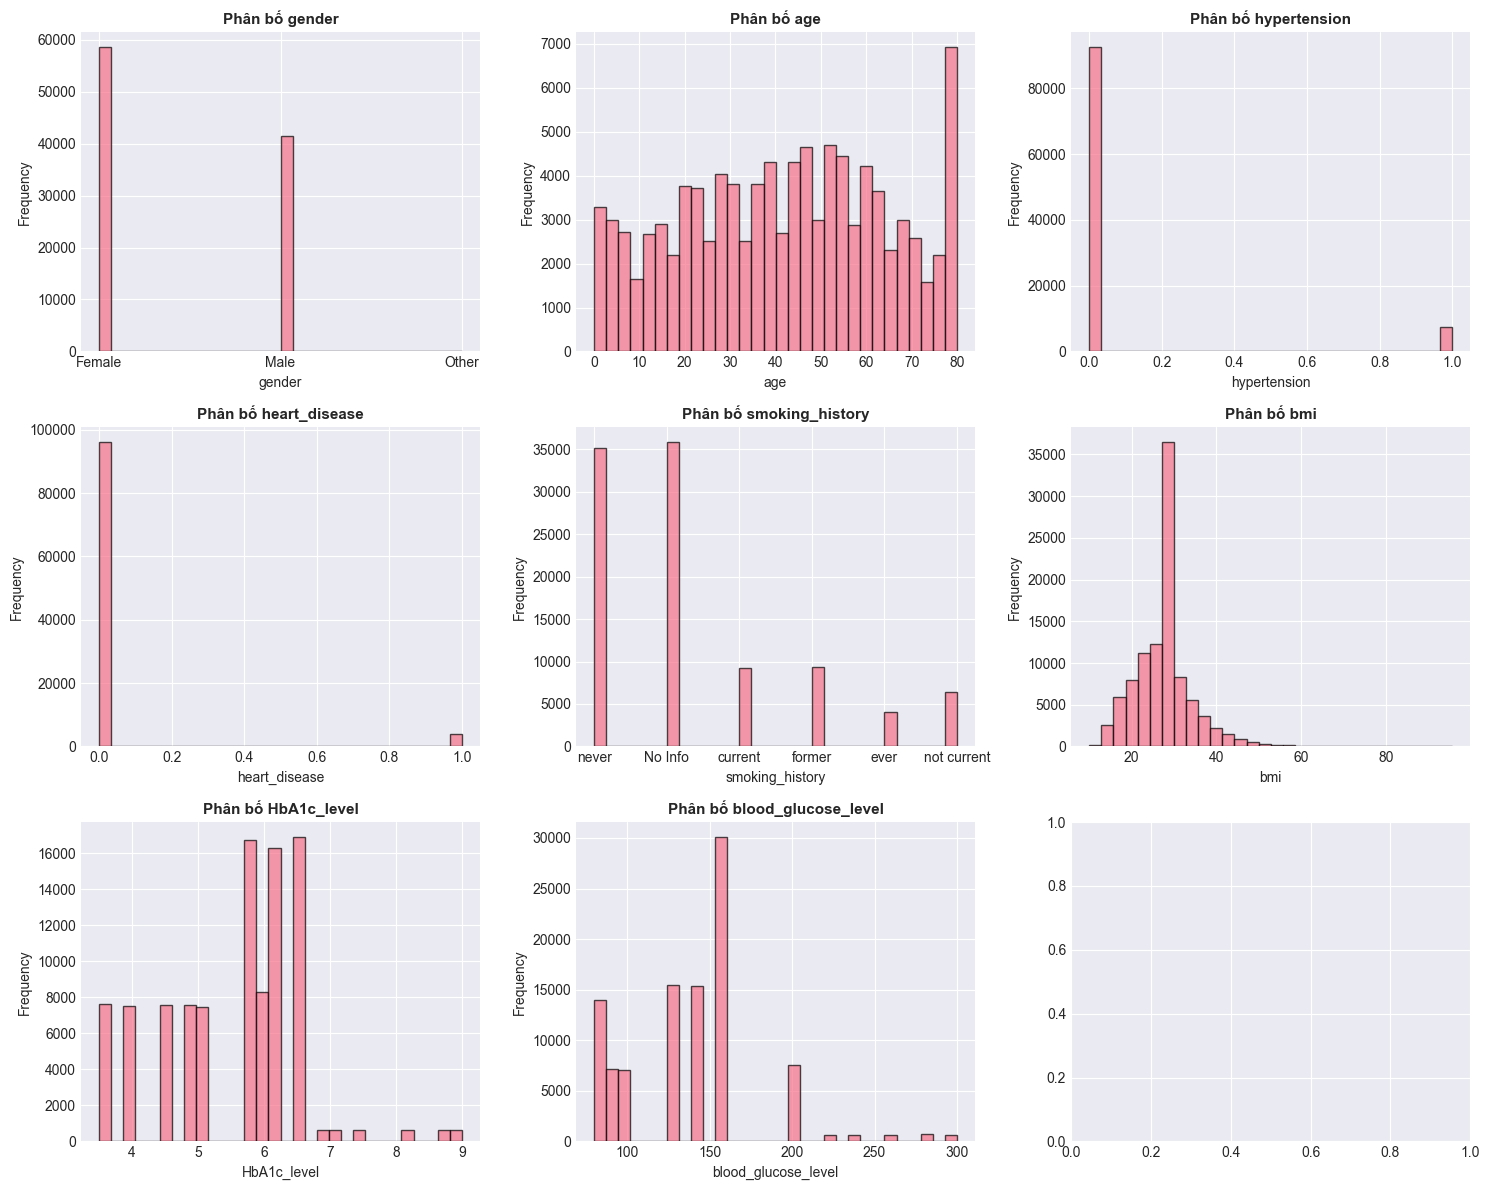

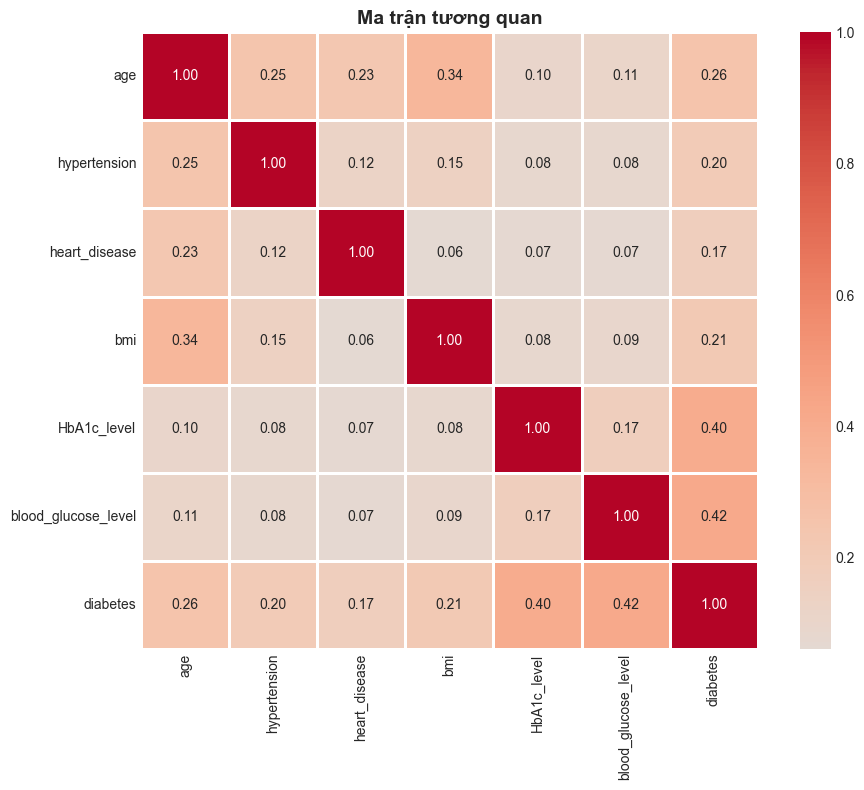

In [3]:
print("\n[2] PHÂN TÍCH TRỰC QUAN DỮ LIỆU")
print("-" * 70)

# 2.1. Phân bố các features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
features = df.columns[:-1]

for idx, col in enumerate(features):
    ax = axes[idx//3, idx%3]
    df[col].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Phân bố {col}', fontsize=11, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2.2. Correlation matrix
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Ma trận tương quan', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### PHẦN 3: TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
print("\n[3] TIỀN XỬ LÝ DỮ LIỆU")
print("-" * 70)

data = df.copy()

# Thay thế giá trị 0 bằng median
print("\nThay thế giá trị 0 bằng median...")
cols_to_replace = ['blood_glucose_level', 'hypertension', 'heart_disease', 'HbA1c_level', 'bmi']

for col in cols_to_replace:
    median_val = data[data[col] != 0][col].median()
    data[col] = data[col].replace(0, median_val)
    print(f"  {col}: thay {(df[col] == 0).sum()} giá trị 0 bằng {median_val:.2f}")

# Tạo features mới
print("\nTạo features mới...")
data['BMI_Category'] = pd.cut(data['bmi'], 
                               bins=[0, 18.5, 25, 30, 100],
                               labels=[0, 1, 2, 3])
data['Age_Group'] = pd.cut(data['age'],
                            bins=[0, 30, 40, 50, 100],
                            labels=[0, 1, 2, 3])
data['Glucose_Level'] = pd.cut(data['blood_glucose_level'],
                                bins=[0, 100, 125, 200],
                                labels=[0, 1, 2])
data['Glucose_Level'].fillna(0, inplace=True) 
data['BMI_Category'].fillna(0, inplace=True)
data['Age_Group'].fillna(0, inplace=True)
# Chuyển sang numeric
data['BMI_Category'] = data['BMI_Category'].astype(int)
data['Age_Group'] = data['Age_Group'].astype(int)
data['Glucose_Level'] = data['Glucose_Level'].astype(int)

# Chuẩn bị features và target
feature_cols = df.columns[:-1].tolist() + ['BMI_Category', 'Age_Group', 'Glucose_Level']
X = data[feature_cols]
y = data['diabetes']

print(f"\nSố lượng features: {len(feature_cols)}")
print(f"Features: {feature_cols}")
print(f"Kích thước X: {X.shape}, y: {y.shape}")
categorical_cols = ['gender', 'smoking_history']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.fillna(0, inplace=True) 




[3] TIỀN XỬ LÝ DỮ LIỆU
----------------------------------------------------------------------

Thay thế giá trị 0 bằng median...
  blood_glucose_level: thay 0 giá trị 0 bằng 140.00
  hypertension: thay 92515 giá trị 0 bằng 1.00
  heart_disease: thay 96058 giá trị 0 bằng 1.00
  HbA1c_level: thay 0 giá trị 0 bằng 5.80
  bmi: thay 0 giá trị 0 bằng 27.32

Tạo features mới...

Số lượng features: 11
Features: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'BMI_Category', 'Age_Group', 'Glucose_Level']
Kích thước X: (100000, 11), y: (100000,)


#### PHẦN 4: CHIA DỮ LIỆU

In [22]:
print("\n[4] CHIA DỮ LIỆU TRAIN/TEST")
print("-" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Tỷ lệ class trong train: \n{y_train.value_counts(normalize=True)}")
print(f"Tỷ lệ class trong test: \n{y_test.value_counts(normalize=True)}")
feature_cols = X_train.columns.tolist()


[4] CHIA DỮ LIỆU TRAIN/TEST
----------------------------------------------------------------------
Train set: (80000, 16)
Test set: (20000, 16)
Tỷ lệ class trong train: 
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64
Tỷ lệ class trong test: 
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


#### PHẦN 5: XÂY DỰNG CÂY QUYẾT ĐỊNH


[5] XÂY DỰNG CÂY QUYẾT ĐỊNH
----------------------------------------------------------------------

5.1. Decision Tree cơ bản (max_depth=5)
Accuracy trên train: 0.9718
Accuracy trên test: 0.9723

5.2. Tìm tham số tối ưu với GridSearchCV
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

 Tham số tốt nhất: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 20}
 ROC AUC tốt nhất (CV): 0.9731

Accuracy trên train: 0.9719
Accuracy trên test: 0.9720

5.3. Vẽ biểu đồ ảnh hưởng của max_depth


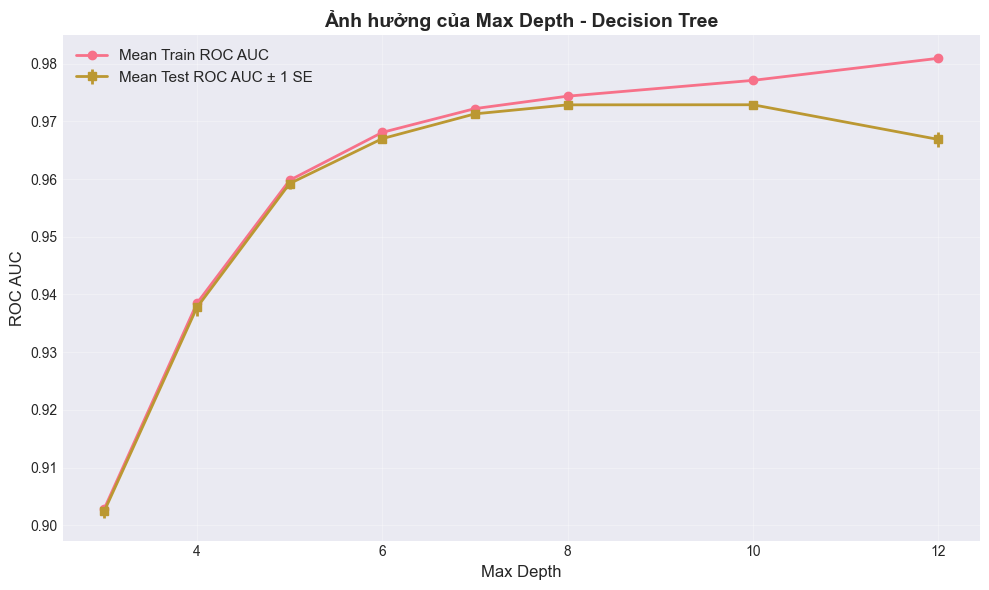

In [13]:
print("\n[5] XÂY DỰNG CÂY QUYẾT ĐỊNH")
print("-" * 70)

# 5.1. Decision Tree cơ bản
print("\n5.1. Decision Tree cơ bản (max_depth=5)")
dt_basic = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_basic.fit(X_train, y_train)

train_acc_basic = dt_basic.score(X_train, y_train)
test_acc_basic = dt_basic.score(X_test, y_test)

print(f"Accuracy trên train: {train_acc_basic:.4f}")
print(f"Accuracy trên test: {test_acc_basic:.4f}")

# 5.2. Tìm tham số tối ưu với GridSearchCV
print("\n5.2. Tìm tham số tối ưu với GridSearchCV")

dt_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(
    dt,
    param_grid=dt_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_dt.fit(X_train, y_train)

print(f"\n Tham số tốt nhất: {grid_dt.best_params_}")
print(f" ROC AUC tốt nhất (CV): {grid_dt.best_score_:.4f}")

best_dt = grid_dt.best_estimator_
train_acc_dt = best_dt.score(X_train, y_train)
test_acc_dt = best_dt.score(X_test, y_test)

print(f"\nAccuracy trên train: {train_acc_dt:.4f}")
print(f"Accuracy trên test: {test_acc_dt:.4f}")

# 5.3. Vẽ biểu đồ learning curve
print("\n5.3. Vẽ biểu đồ ảnh hưởng của max_depth")

cv_results = pd.DataFrame(grid_dt.cv_results_)
depth_results = cv_results[cv_results['param_criterion'] == grid_dt.best_params_['criterion']]
depth_results = depth_results.groupby('param_max_depth').agg({
    'mean_train_score': 'mean',
    'mean_test_score': 'mean',
    'std_test_score': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.errorbar(depth_results['param_max_depth'], 
             depth_results['mean_train_score'],
             label='Mean Train ROC AUC', marker='o', linewidth=2)
plt.errorbar(depth_results['param_max_depth'],
             depth_results['mean_test_score'],
             yerr=depth_results['std_test_score']/np.sqrt(5),
             label='Mean Test ROC AUC ± 1 SE', marker='s', linewidth=2)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('Ảnh hưởng của Max Depth - Decision Tree', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### PHẦN 6: XÂY DỰNG RANDOM FOREST


[6] XÂY DỰNG RANDOM FOREST
----------------------------------------------------------------------

6.1. Random Forest cơ bản (n_estimators=100)
Accuracy trên train: 0.9718
Accuracy trên test: 0.9723

6.2. Tìm tham số tối ưu cho Random Forest
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

✓ Tham số tốt nhất: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
✓ ROC AUC tốt nhất (CV): 0.9720

Accuracy trên train: 0.9718
Accuracy trên test: 0.9723

6.3. Phân tích Feature Importance
                        Feature    Importance
4                   HbA1c_level  5.056388e-01
5           blood_glucose_level  3.768007e-01
0                           age  3.763355e-02
3                           bmi  2.730935e-02
7                     Age_Group  2.481800e-02
6                  BMI_Category  1.243682e-02
8                 Glucose_Level  9.675503e-03
13       smoking_history_former  1.893998e-03
9                   gende

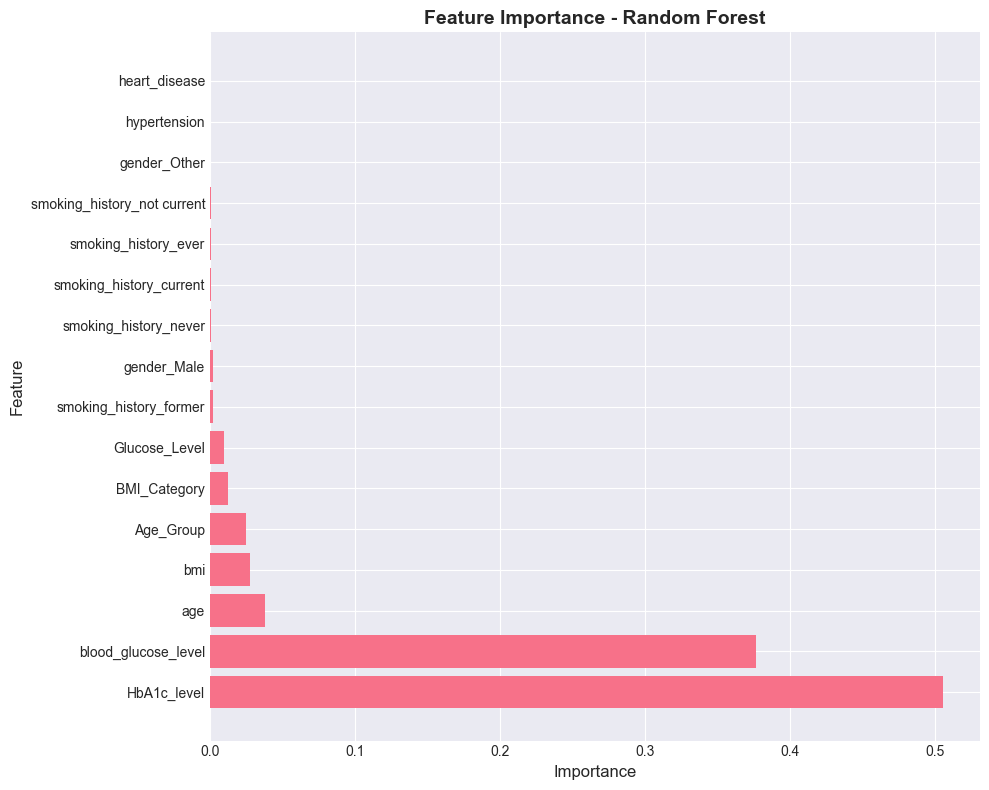


6.4. Vẽ biểu đồ ảnh hưởng của n_estimators


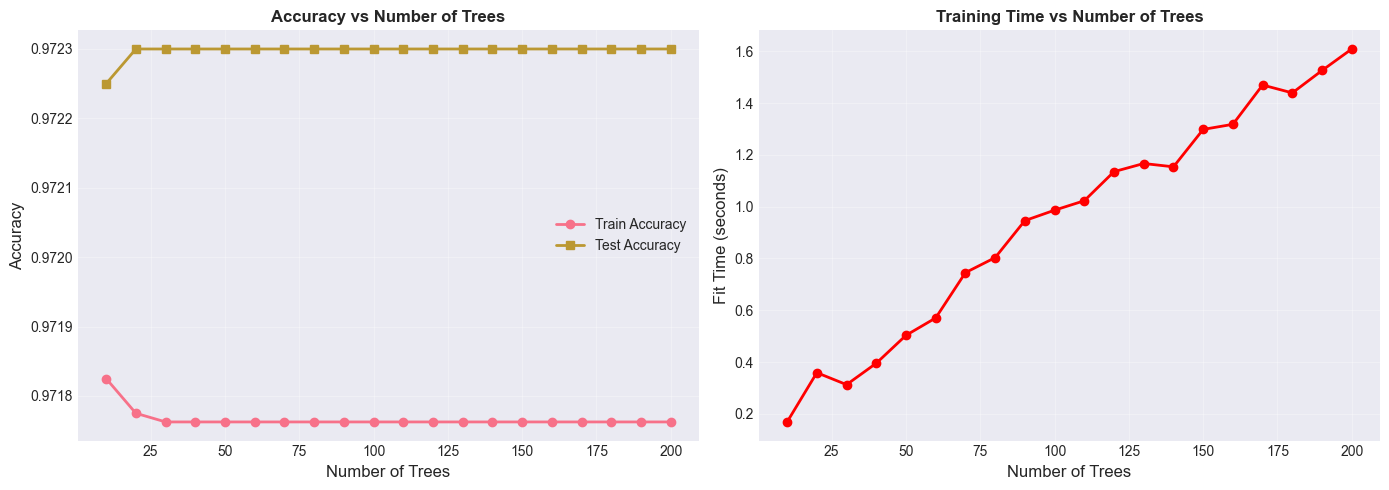

In [27]:
print("\n[6] XÂY DỰNG RANDOM FOREST")
print("-" * 70)

# 6.1. Random Forest cơ bản
print("\n6.1. Random Forest cơ bản (n_estimators=100)")

rf_basic = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf_basic.fit(X_train, y_train)

train_acc_rf_basic = rf_basic.score(X_train, y_train)
test_acc_rf_basic = rf_basic.score(X_test, y_test)

print(f"Accuracy trên train: {train_acc_rf_basic:.4f}")
print(f"Accuracy trên test: {test_acc_rf_basic:.4f}")

# 6.2. Tìm tham số tối ưu
print("\n6.2. Tìm tham số tối ưu cho Random Forest")

rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(
    rf,
    param_grid=rf_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

print(f"\n✓ Tham số tốt nhất: {grid_rf.best_params_}")
print(f"✓ ROC AUC tốt nhất (CV): {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_
train_acc_rf = best_rf.score(X_train, y_train)
test_acc_rf = best_rf.score(X_test, y_test)

print(f"\nAccuracy trên train: {train_acc_rf:.4f}")
print(f"Accuracy trên test: {test_acc_rf:.4f}")

# 6.3. Feature Importance
print("\n6.3. Phân tích Feature Importance")

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6.4. Vẽ biểu đồ ảnh hưởng của n_estimators
print("\n6.4. Vẽ biểu đồ ảnh hưởng của n_estimators")

n_trees = range(10, 201, 10)
train_scores_rf = []
test_scores_rf = []
fit_times = []

import time
for n in n_trees:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=grid_rf.best_params_['max_depth'],
        random_state=42,
        n_jobs=-1
    )
    start_time = time.time()
    rf_temp.fit(X_train, y_train)
    fit_times.append(time.time() - start_time)
    train_scores_rf.append(rf_temp.score(X_train, y_train))
    test_scores_rf.append(rf_temp.score(X_test, y_test))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs n_estimators
axes[0].plot(n_trees, train_scores_rf, 'o-', label='Train Accuracy', linewidth=2)
axes[0].plot(n_trees, test_scores_rf, 's-', label='Test Accuracy', linewidth=2)
axes[0].set_xlabel('Number of Trees', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Number of Trees', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Fit time vs n_estimators
axes[1].plot(n_trees, fit_times, 'o-', color='red', linewidth=2)
axes[1].set_xlabel('Number of Trees', fontsize=12)
axes[1].set_ylabel('Fit Time (seconds)', fontsize=12)
axes[1].set_title('Training Time vs Number of Trees', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
